In [319]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [320]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [306]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [307]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [308]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [309]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [310]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore(dat): return (dat-np.mean(dat))/np.std(dat)

In [311]:
def loop_distance_matrix(seq,p=2):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = min([abs(ind1-ind2),abs(9+(ind1-ind2)),abs(9+(ind2-ind1))])**p
    return d

In [312]:
def line_distance_matrix(seq,p=1):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = abs(ind1-ind2)**p
    return d

In [313]:
import statsmodels.api as sm

In [314]:
def remove_diagonal(A):
    removed = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], int(A.shape[0])-1, -1)
    return np.squeeze(removed)


# Get task distances 

In [315]:
def get_C_loop_task(seq0,p=0.95):
    """p is the probability of continueing in the same direction"""
    #this constructs the appropriate things if everything is ordered correctly according to states

    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

    task_1_distance = -np.log(expm(T1))
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [316]:
def get_C_line_task(seq0,p=0.95):
    """ Finish this requires updating the edges of the line"""
    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

        

    T1[seq0[0]] = 0; T1[seq0[0],seq0[1]] = 1  #going to the right in state 0 will go to 1
    T1[seq0[8]] = 0; T1[seq0[8],seq0[-1]+9] = 1   #going to the right in state 9 will go to state 8
    T1[seq0[9%9]+9] = 0; T1[seq0[9%9]+9,seq0[0]] = 1    #going to the left in state 0 will go to state 1
    T1[seq0[-1]+9] = 0; T1[seq0[-1]+9,seq0[-2]+9] = 1       #going to the left in state 
    
    task_1_distance = -np.log(expm(T1))
    #evals,evecs = np.linalg.eig(T1)
    #mx = np.max(np.abs(evals))
    #task_1_distance = (evecs@(evals_mtx**50)@np.linalg.inv(evecs)).real
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [317]:
from scipy.linalg import expm

# batch over all tasks

In [295]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mxs = np.nanmax(firing_rate_maps,axis=(1,2,3))
    firing_rate_maps = firing_rate_maps[np.logical_and(mxs<5,mxs>0.0001)]
    #spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]

   
    
    frm = np.hstack([mds_frm[:,:,0,0],mds_frm[:,:,0,1],mds_frm[:,:,1,0],mds_frm[:,:,1,1]]).T
    frm = ((frm-np.nanmean(frm,axis=0))/np.nanstd(frm,axis=0))

    if graph_type0=='loop': 
        task_1_distance = get_C_loop_task(seq0)[1]
    else: 
        task_1_distance =  get_C_line_task(seq0)[1]
    if graph_type1=='loop':
        task_2_distance = get_C_loop_task(seq1)[1]
    else:
        task_2_distance = get_C_line_task(seq1)[1]

    task_1_distance = np.nan_to_num(task_1_distance,np.nanmean(task_1_distance))
    task_2_distance = np.nan_to_num(task_2_distance,np.nanmean(task_2_distance))
    #spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    spatial_distance =   -distance_matrix(np.vstack([poke_pos,poke_pos,poke_pos,poke_pos]),
                                          np.vstack([poke_pos,poke_pos,poke_pos,poke_pos]),p=1)
    
    tmp = zscore(np.tile([0]*9 + [1]*9,2))
    hd_distance = -distance_matrix(tmp.reshape(-1,1),tmp.reshape(-1,1))
    tmp2 = zscore(np.array([0]*9 + [1]*9 + [1]*9 + [0]*9))
    hd_distance2 = -distance_matrix(tmp2.reshape(-1,1),tmp2.reshape(-1,1))
    
    
    tmp = np.concatenate([np.ones(18),-1*np.ones(18)])
    task_distance = -distance_matrix(tmp.reshape(-1,1),tmp.reshape(-1,1))

    task_corrs = np.corrcoef(frm)

    select_indices = (np.eye(len(task_corrs)) + 
                      np.isnan(task_corrs) + 
                    #  np.isnan(task2_corrs) + 
                    #  np.isnan(task_1_distance) + 
                    #  np.isnan(task_2_distance) + 
                      np.isnan(spatial_distance)
                     )==0
    
    #
    y = task_corrs[select_indices].flatten()
    
    spd = zscore(spatial_distance[select_indices].flatten())
    hdd1 = zscore(hd_distance[select_indices].flatten())
    hdd2 = zscore(hd_distance2[select_indices].flatten())
    td = zscore(task_distance[select_indices].flatten())
    
    X = np.vstack([np.ones_like(y), #0
                   spd,             #1 
                   hdd1,            #2
                   hdd2,            #3
                   td,              #4
                   #interactions
#                    spd*hdd1,        #5
#                    spd*hdd2,        #6
#                    spd*td,          #7
#                    hdd1*td,         #8
#                    hdd2*td,         #9
#                    #two way interactions
#                    spd*hdd1*td,
#                    spd*hdd2*td
    
                
                   
              ]).T
    
    #y = remove_diagonal(task1_corrs).flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
  
    all_beta.append(res.params)
    all_pvals.append(res.pvalues)
    #assert np.allclose(beta,res.params)
all_pvals = np.array(all_pvals)
all_beta = np.array(all_beta)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

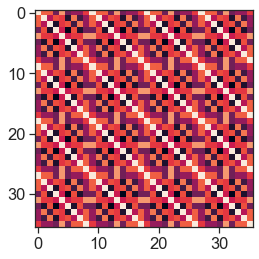

In [296]:
plt.imshow(spatial_distance)

In [297]:
#np.array(all_pvals)[:,-1].flatten()[3]

In [298]:
mn_hd = np.min(np.array(all_pvals)[:,2:4],axis=1)

No handles with labels found to put in legend.


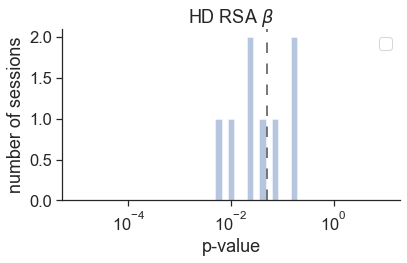

In [299]:
mn_hd = np.min(np.array(all_pvals)[:,2:4],axis=1)
seaborn.distplot(mn_hd,bins=np.logspace(-5,1,num=50),kde=0)
plt.title(r"HD RSA $\beta$")
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

No handles with labels found to put in legend.


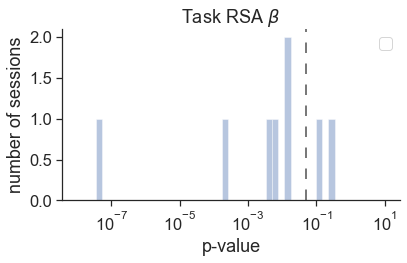

In [303]:
#mn_hd = np.min(np.array(all_pvals)[:,4],axis=1)
seaborn.distplot(np.array(all_pvals)[:,4],bins=np.logspace(-8,1,num=50),kde=0)
plt.title(r"Task RSA $\beta$")
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

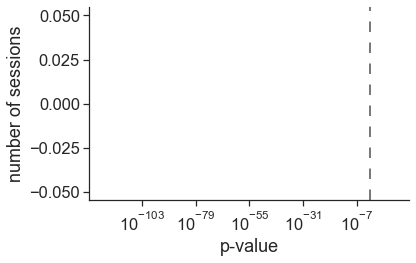

In [293]:
seaborn.distplot(np.clip(np.array(all_pvals)[:,3].flatten(),1e-12,0),kde=0,bins=np.logspace(-120,10,num=50),)
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
seaborn.despine()
plt.tight_layout()

No handles with labels found to put in legend.


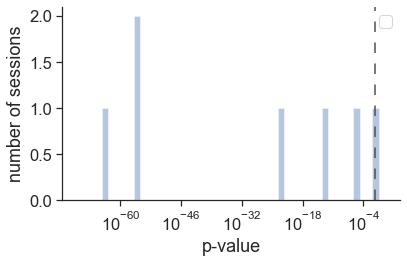

In [294]:
seaborn.distplot(np.array(all_pvals)[:,1].flatten(),kde=0,bins=np.logspace(-70,1,num=50),)
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

No handles with labels found to put in legend.


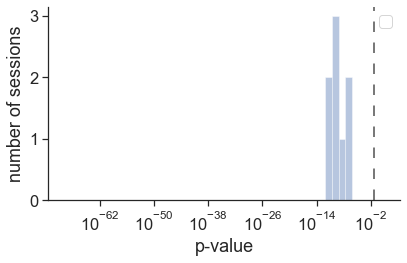

In [199]:
seaborn.distplot(np.array(all_pvals)[:,0].flatten(),kde=0,bins=np.logspace(-70,1,num=50),)
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [163]:
#plt.imshow(select_indices)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

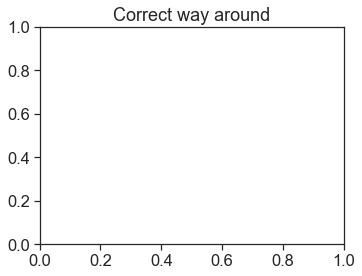

In [164]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [38]:
np.array(all_beta).shape

(8, 2, 4)

In [39]:
t1_m_t2_inT1

array([ 0.00771686, -0.032119  ,  0.05740197,  0.05647009,  0.01398327,
        0.03494894, -0.00462993,  0.01152955])

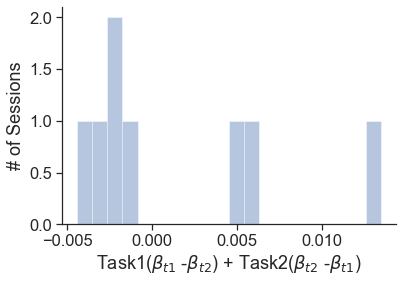

In [40]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

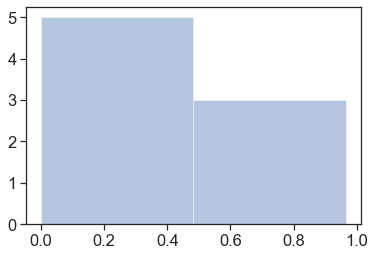

In [102]:
seaborn.distplot(np.array(all_pvals)[:,-1],kde=0)

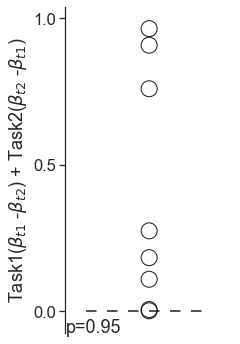

In [100]:
plt.figure(figsize=(3,6))
plt.scatter([0]*8,t1_m_t2_inT1 + t1_m_t2_inT2,s=256,facecolor='',edgecolor='k')
plt.annotate('p=0.95',(.0,0),xycoords='axes fraction')
plt.xticks([])
plt.plot([-.15,.15],[0,0],color='k',linestyle='--',dashes=(7,7))
plt.ylabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.xlim(-.2,.2)
plt.locator_params('y',nbins=3)
seaborn.despine(bottom=True)

In [2362]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,0)

Ttest_1sampResult(statistic=0.7445967465797968, pvalue=0.4807604377694731)

In [42]:
    spatial_distance =   -distance_matrix(np.vstack([poke_pos[seq0],poke_pos[seq0],poke_pos[seq0],poke_pos[seq0]]),
                                          np.vstack([poke_pos[seq0],poke_pos[seq0],]),p=1)


In [43]:
spatial_distance.shape

(18, 18)

# Check this works by ordering according to sequence